# Test Sketching Methods

## Test Loading in Seqs

In [164]:
import os
import subprocess
from Bio.Seq import Seq
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from itertools import repeat

In [165]:
example_fastq = "/data/wford/sv_merge/output/HG002_20bp/chr1/chr1_7905147-7905547.fastq"
seqs, labels = readFastq(example_fastq)
seqs, labels = zip(*sorted(zip(seqs, labels), key = lambda x : x[1]))
print(len(seqs))
seqs,labels

12


(('TGCTGTCCCATATTAGAAGCATAAGGGTACACCCAAGATTGAGTCCCACTTTTTTTGGTAATTATATCATTATTACCACATCACCCAAGAAGTCTGGACACTCCCCTGAGGAAGGGGAGGGAGTGCAATAGAAGATGAGGTCTGGAGACTCCCACACACGGTATCCAGGGTGTCTGCAGCCTGCCACCTACCATCAGGTCGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGGTGTGTTTTAAATTAAGCCAAAGAAGGACTCAGTCCTTTGTAAATAACCGTATGCGCACCCCCTTTCGATTCAGTTCACAGAGAACAGTGAGAATCTTCCACTGTCACAACACAGTTTTACGACCAACAGCAAAGAATGATGAGGACTGCTGGCCTTACGGCTATGTTAA',
  'TGCTGTCCCATATTAGAAGCATAAGGGTACACCCAAGATTGAGTCCCACTTTTTTTGGTAATTATATCATTATTACCACATCACCCAAGAAGTCTGGACACTCCCCTGAGGAAGGGGAGGGAGTGCAATAGAAGATGAGGTCTGGAGACTCCCACACACGGTATCCAGGGTGTCTGCAGCCTGCCACCTACCATCAGGTCGTGTGTGTGTGTGGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTTTTAAATTAAGCCAAAGAAGGACTCAGTCCTTTGTAAATAACCGTATGCGCACCCCCTTTCGATTCAGTTCACAGAGAACAGTGAGAATCTTCCACTGTCACAACACAGTTTTACGACCAACAGCAAAGAATGATGAGGACTGCTGGCCTTACGGCTATGTTAA',
  'TGCTGTCCCATATTAGAAGCATAAGGGTACACCCAAGATTGAGTCCCACTTTTTTGGTAATTATATCATTATTACCACATCACCCAAGAAGTCTGGACACTCCCCTGAGGAAGGGGAGGGAGTGCAATAGA

Reading in the seqs and sorting them is done correctly without losing any information.

We can see that the top 3 reads have a longer GT repeat than the other reads

## Test loading in kmer tables

In [166]:
kmer_table_path = "/data/wford/sv_merge/output/kmerTables_20bp/21mers/chr1/chr1_7905147-7905547"
for i in range(1, len(seqs)+1):
    tableFile = os.path.join(kmer_table_path, f"read{i}.ktab")
    command = ["Tabex", tableFile, "LIST"]
    table_output = str(subprocess.check_output(command))
    
    fastk_read_counts = dict()
    for row in  table_output.split("\\n")[1:-1]: # First and last line don't contain kmers
        kmer, count = row.strip().split("=")
        kmer = kmer.split(":")[1].strip().upper()
        count = int(count.strip())

        fastk_read_counts[kmer] = count

    read = seqs[i-1]
    read_counts = dict()

    for i in range(len(read)-21+1):
        kmer = read[i:i+21]
        read_counts[kmer] = read_counts.setdefault(kmer, 0) + 1

    in_raw_only = []
    for kmer in read_counts.keys():
        if read_counts[kmer] != fastk_read_counts.setdefault(kmer, "Not present!"):
            in_raw_only.append(kmer)
    in_fastk_only = []
    for kmer in fastk_read_counts.keys():
        if read_counts.setdefault(kmer, "Not present!") != fastk_read_counts[kmer]:
            in_fastk_only.append(kmer)

    for seq in in_raw_only:
        seq = Seq(seq)
        if seq.reverse_complement() not in in_fastk_only:
            print(seq)

Generating the kmer tables and using fastk is done correctly without losing any information. They just use the lexicographically smallest between a kmer and its reverse compliment.

Now we test if turning kmer tables to a vector has an error.

In [167]:
kmer_dict = dict()
next_kmer_index = 0
minKmerRead = 750
m = M = 24000

firstOcc = [0 for _ in range(len(set(labels)))]
for i, item in enumerate(sorted(set(labels))):
    firstOcc[i] = labels.index(item)

In [168]:
for i in range(len(seqs)):
    tableFile = os.path.join(kmer_table_path, f"read{i + 1}.ktab")
    command = ["Tabex", tableFile, "LIST"]
    table_output = str(subprocess.check_output(command))

    characteristicVector = np.zeros(minKmerRead, dtype=np.int16)
    fastk_read_counts = dict()

    for row in  table_output.split("\\n")[1:-1]: # First and last line don't contain kmers
        kmer, count = row.strip().split("=")
        kmer = kmer.split(":")[1].strip().upper()
        count = int(count.strip())

        fastk_read_counts[kmer] = count

        # Get kmer index
        if kmer not in kmer_dict.keys():
            kmer_dict[kmer] = next_kmer_index
            next_kmer_index += 1
        
        localIndex = kmer_dict[kmer]
        if localIndex >= minKmerRead:
            if minKmerRead * 2 > m:
                addValue = m - localIndex
            else: addValue = minKmerRead
            characteristicVector = np.concatenate((characteristicVector, np.zeros(addValue)), axis=0)
            minKmerRead *= 2
        characteristicVector[localIndex] = count

    print("Kmer Dictionary vs Kmer Vector")
    kmers, values = zip(*fastk_read_counts.items())
    print("max\t\t\t", max(values),max(characteristicVector))
    print("Num 1's\t\t\t", values.count(1), sum(characteristicVector == 1))
    print("Unique Values\t\t", set(values), np.unique(characteristicVector))
    print("Length ignoring 0's\t", len(values), len(characteristicVector) - sum(characteristicVector == 0))
    print("Length of vector\t", len(characteristicVector))

Kmer Dictionary vs Kmer Vector
max			 19 19
Num 1's			 370 370
Unique Values		 {1, 18, 19} [ 0  1 18 19]
Length ignoring 0's	 372 372
Length of vector	 750
Kmer Dictionary vs Kmer Vector
max			 15 15
Num 1's			 377 377
Unique Values		 {1, 15} [ 0  1 15]
Length ignoring 0's	 379 379
Length of vector	 750
Kmer Dictionary vs Kmer Vector
max			 20 20
Num 1's			 362 362
Unique Values		 {1, 20} [ 0  1 20]
Length ignoring 0's	 364 364
Length of vector	 750
Kmer Dictionary vs Kmer Vector
max			 9 9
Num 1's			 363 363
Unique Values		 {1, 9} [0 1 9]
Length ignoring 0's	 365 365
Length of vector	 750
Kmer Dictionary vs Kmer Vector
max			 10 10
Num 1's			 364 364
Unique Values		 {1, 10} [ 0  1 10]
Length ignoring 0's	 366 366
Length of vector	 750
Kmer Dictionary vs Kmer Vector
max			 9 9
Num 1's			 364 364
Unique Values		 {1, 9} [0 1 9]
Length ignoring 0's	 366 366
Length of vector	 750
Kmer Dictionary vs Kmer Vector
max			 9 9
Num 1's			 362 362
Unique Values		 {1, 9} [0 1 9]
Length ignoring 0's

The vector is correctly generating as well.

## Test Performing a single hash

### Euclidean Hash

In [171]:
"""
Generate signatureMatrix of hashs x seqs
    A hash, in this case, is the projection of the seqs characteristicMatrix
    represenation onto a random line.
"""
def projectionSignature(randLines, randOffsets, numHashes, n, binWidth):
    kmer_dict = dict()
    signatureMatrix = np.zeros((numHashes, n))
    for i in range(n):
        characteristicVector, kmer_dict = getCharacteristicVector(i, kmer_dict)
        length = characteristicVector.shape[0]
        for j in range(numHashes):
            direction = randLines[j][0:length]
            offset = randOffsets[j]
            signatureMatrix[j,i] = projectAndBin(characteristicVector, direction, offset, binWidth)
    return signatureMatrix

"""
Compute projection of point onto a random line and calculate which bin the point falls into.
Returns pos or neg integer indicating which bin projected into. i.e.
    |-2|-1|0(contains origin at leftmost boundary)|1|2|
"""
def projectAndBin(characteristicVector, line, offset, binWidth):
    projection = np.dot(line,characteristicVector)*line + offset
    projectedWidth = line[0] * binWidth
    return int(projection[0] // projectedWidth)

"""
Generate Characteristic vector from FastK
"""
def getCharacteristicVector(i, kmer_dict, minKmerRead = minKmerRead):
    tableFile = os.path.join(kmer_table_path, f"read{i + 1}.ktab")
    command = ["Tabex", tableFile, "LIST"]
    table_output = str(subprocess.check_output(command))

    characteristicVector = np.zeros(minKmerRead, dtype=np.int16)
    fastk_read_counts = dict()

    for row in  table_output.split("\\n")[1:-1]: # First and last line don't contain kmers
        kmer, count = row.strip().split("=")
        kmer = kmer.split(":")[1].strip().upper()
        count = int(count.strip())

        fastk_read_counts[kmer] = count

        # Assign unknown kmer ids
        if kmer not in kmer_dict.keys():
            kmer_dict[kmer] = len(kmer_dict)
        
        localIndex = kmer_dict[kmer]
        if localIndex >= minKmerRead:
            if minKmerRead * 2 > m:
                addValue = m - localIndex
            else: addValue = minKmerRead
            characteristicVector = np.concatenate((characteristicVector, np.zeros(addValue)), axis=0)
            minKmerRead *= 2
        characteristicVector[localIndex] = count
    return characteristicVector, kmer_dict

"""
Generate random lines for euclidean projecting
"""
def genRandomLines():
    m = 750
    randLines = []
    randOffsets = []
    for _ in range(20000):
        s = np.random.normal(0, 1, m)
        direction = s / np.sqrt(sum(s*s))
        randLines.append(direction)

        offset = np.random.uniform(1,5,m)
        randOffsets.append(offset)
    return randLines, randOffsets

In [172]:
randLines, randOffsets = genRandomLines()
n: int = len(seqs)
numHashes = 1000
binWidth = 1
signatureMatrix = projectionSignature(randLines, randOffsets, numHashes, n, binWidth)
signatureMatrix, signatureMatrix.shape

(array([[-212., -212., -212., ..., -212., -212., -212.],
        [ 119.,  119.,  120., ...,  120.,  120.,  119.],
        [ -45.,  -46.,  -45., ...,  -46.,  -46.,  -47.],
        ...,
        [  54.,   53.,   53., ...,   53.,   53.,   52.],
        [-231., -231., -231., ..., -231., -230., -231.],
        [-180., -180., -179., ..., -180., -180., -180.]]),
 (1000, 12))

In [173]:
"""
Use banding technique to bin reads by similarity
"""
def band(signatureMatrix, numHashes,n, bandLength):
    def connectBucket(bucket, adjacencyMatrix):
        for i in range(len(bucket)-1):
            for j in range(i+1, len(bucket)):
                adjacencyMatrix[bucket[i],bucket[j]] = True
                adjacencyMatrix[bucket[j],bucket[i]] = True
        return adjacencyMatrix
    adjacencyMatrix = np.eye(n, dtype = bool)
    for i in range(numHashes//bandLength):
        buckets = defaultdict(list[int])
        startBucket = i*bandLength
        endBucket = (i+1)*bandLength
        for j in range(n):
            buckets[signatureMatrix[startBucket:endBucket, j].tobytes()].append(j)
        for bucket in buckets.values():
            adjacencyMatrix = connectBucket(bucket, adjacencyMatrix)
    return adjacencyMatrix

"""
Plot adjacencyMatrix
"""
def plotAdjacencyMatrix(adjacencyMatrix, firstOcc, n):
    plt.imshow(adjacencyMatrix, 
                cmap = 'binary_r', 
                interpolation='nearest', 
                vmin=0, vmax=1
    )
    plt.title(f"Adjacency Matrix")
    plt.xticks(np.arange(n), np.arange(1, n + 1))
    plt.yticks(np.arange(n), np.arange(1, n + 1))

    plt.tick_params(axis='x', top=True, bottom=False, labeltop=True, labelbottom=False)
    plt.xlabel(f"White in pos i,j indicates i connects j")
    for x in firstOcc[1:]:
        plt.axhline(x - 0.5, color='red', linestyle='-', linewidth=2)
        plt.axvline(x - 0.5, color='red', linestyle='-', linewidth=2)
    plt.show()

"""
Generate TPR FPR curve as bandLength varies over all possible values
    1 --> total number of hashes
"""
def plotTPRFPRCurve(signatureMatrix, firstOcc):
    """
    Plot the ROC curve with area under curve labeled.
    """
    def plotROC(tprs, fprs):
        # Plot the ROC curve
        plt.figure()  
        plt.plot(fprs, tprs)
        #plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve')
        plt.legend()
        plt.show()

    """
    Calculate TPR, FPR from adjacency matrix
    """
    def TPR_FPR(adjacencyMatrix, n, firstOcc):
        trueMask = np.zeros((n, n), dtype = bool)
        for i in range(0, len(firstOcc)-1):
            trueMask[firstOcc[i]:firstOcc[i+1], firstOcc[i]:firstOcc[i+1]] = 1
        # Add Last Region
        trueMask[firstOcc[-1]:, firstOcc[-1]:] = 1

        # Don't include y=x line.
        tpr = int((np.sum(adjacencyMatrix, where = trueMask) - n)/2) /int((np.sum(trueMask) - n)/2)
        fpr = int(np.sum(adjacencyMatrix, where = ~trueMask)/2) / int(np.sum(~trueMask)/2)

        return tpr, fpr
    
    n = signatureMatrix.shape[1]
    numHashes = len(signatureMatrix)
    tprs, fprs = [0 for _ in repeat(None, numHashes)], [0 for _ in repeat(None, numHashes)]
    for bandLength in range(1, numHashes + 1):
        adjacencyMatrix = band(signatureMatrix, numHashes, n, bandLength)
        tpr, fpr = TPR_FPR(adjacencyMatrix, n, firstOcc)
        tprs.append(tpr)
        fprs.append(fpr)
    plotROC(tprs, fprs)

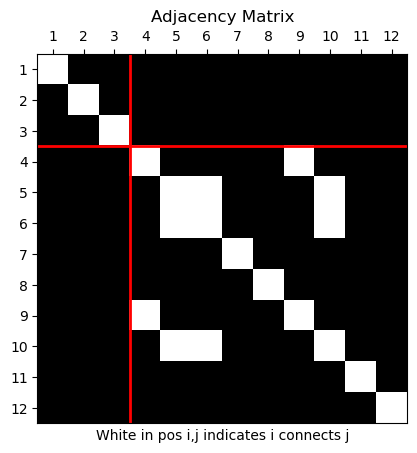

In [174]:
bandLength = 50

adjacencyMatrix = band(signatureMatrix, numHashes, n, bandLength)
plotAdjacencyMatrix(adjacencyMatrix, firstOcc, n)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


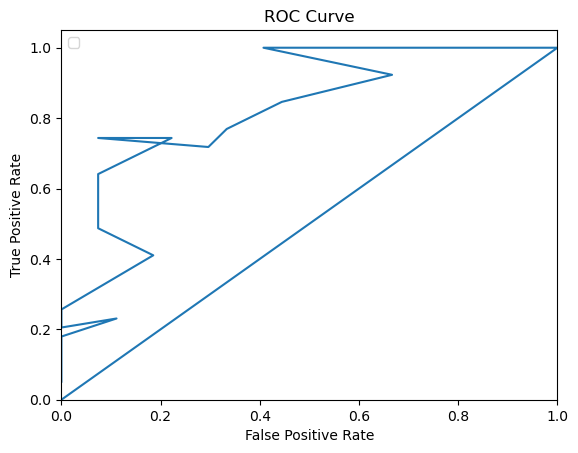

In [175]:
plotTPRFPRCurve(signatureMatrix, firstOcc)

These values look more reasonable than the ones we are using in the saved matrix set. But it could be from the random vectors. Let's try using the saved random vectors.

Compare against the pre-saved characteristic matrices

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


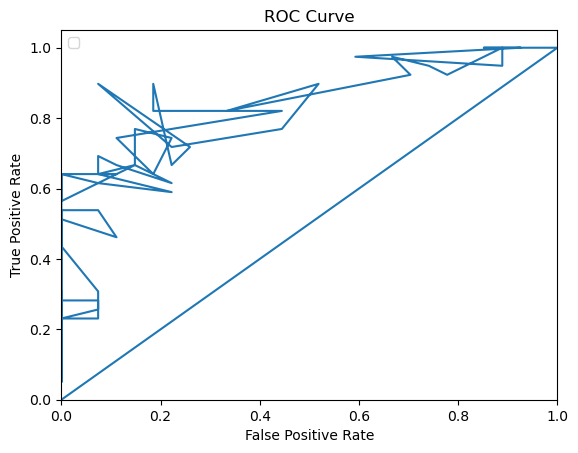

In [176]:
saved_signature_matrix_file = "/data/wford/sv_merge/output/signatureMtxs_20bp/euclidean/1000,21,1,1/chr1_7905147-7905547.npy"
saved_signature_matrix = np.load(saved_signature_matrix_file)
plotTPRFPRCurve(saved_signature_matrix, firstOcc)

These actually look pretty similar. This is not a good sign because our pre-saved distance metrics are not functioning correctly.

#### Test to see if signature matrix correctly approximates euclidean distance

In [207]:
"""
Euclidean Distance from two kmer sets represented as numpy arrays
"""
def euclidean_distance(set_a: np.ndarray, set_b: np.ndarray):
    return np.linalg.norm(set_a - set_b)

"""
Euclidean Distance from two signature vectors represented as numpy arrays

Impossible to calculate directly. Instead we'll just develop an ordering and see if they are associated
"""
def approx_euclidean_distance(set_a: np.ndarray, set_b: np.ndarray):
    return 1 - sum(set_a == set_b) / len(set_a)

"""
Plot exact vs approximate distances
"""
def plot_distances(distance_vector, approx_distance_vector, title:str):
    plt.scatter(approx_distance_vector, distance_vector)
    plt.title(f"Exact vs Approximate: {title.title()} Distance")
    plt.xlabel("Approximate Distance")
    plt.ylabel("Exact Distance")
    plt.show()

    print("Real:")
    print("min\t:", np.min(distance_vector))
    print("mean\t:",np.mean(distance_vector))
    print("max\t:",np.max(distance_vector))
    print("var\t:",np.var(distance_vector))
    print()
    print("Approx:")
    print("min\t:", np.min(approx_distance_vector))
    print("mean\t:",np.mean(approx_distance_vector))
    print("max\t:",np.max(approx_distance_vector))
    print("var\t:",np.var(approx_distance_vector))

In [208]:
char_vector_length = 750 #len(characteristicVector)
characteristic_matrix = np.zeros((750,n))
kmer_dict = dict()
for i in range(n):
    characteristic_matrix[:, i], kmer_dict = getCharacteristicVector(i, kmer_dict)

# This step is not performed in prediction. Shouldn't matter but noted!!
trimmed_characteristic_matrix = characteristic_matrix[0:max(np.where(characteristic_matrix > 0)[0])+1, :]

In [209]:
trimmed_characteristic_matrix.shape, signatureMatrix.shape
approx_distances = []
exact_distances = []
for i in range(12 - 1):
    for j in range(i + 1, 12):
        approx_distances.append( approx_euclidean_distance(signatureMatrix[:,i], signatureMatrix[:,j]) )
        exact_distances.append( euclidean_distance(trimmed_characteristic_matrix[:,i], trimmed_characteristic_matrix[:,j]) )

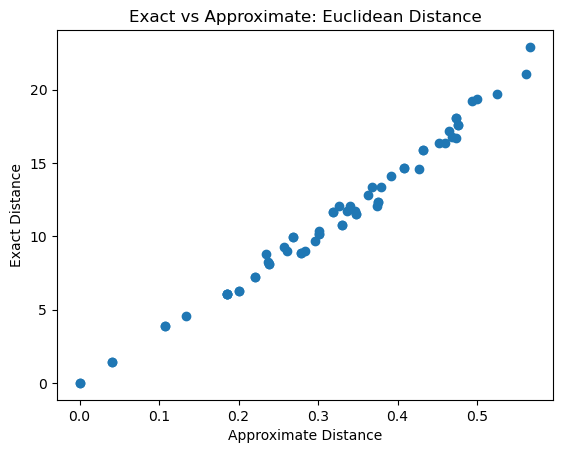

Real:
min	: 0.0
mean	: 11.26488455646278
max	: 22.9128784747792
var	: 25.99631532350573

Approx:
min	: 0.0
mean	: 0.318
max	: 0.567
var	: 0.017474666666666663


In [210]:
plot_distances(exact_distances, approx_distances, "euclidean")

Oh my goodness it does! I found a small bug and now it approximately follows the y = x line like we hoped.

### Jaccard and minHash

In [289]:
"""
Jaccard Distance from two kmer sets represented as numpy arrays
"""
def jaccard_distance(set_a: np.ndarray, set_b: np.ndarray):
    return sum(np.logical_and(set_a, set_b)) / sum(np.logical_or(set_a, set_b))

"""
Jaccard Distance from two signature vectors represented as numpy arrays
"""
def approx_jaccard_distance(set_a: np.ndarray, set_b: np.ndarray):
    return sum(set_a == set_b) / set_a.shape[0]

In [281]:
"""
Generate signatureMatrix of hashs x seqs
"""
def minHashSignature(hashes, numHashes, n):
    kmer_dict = dict()
    signatureMatrix = np.full((numHashes, n), np.inf)
    for k, univ_hash in enumerate(hashes):
        if k == numHashes: break
        for i in range(n):
            characteristicVector, kmer_dict = getCharacteristicVector(i, kmer_dict)
            for kmer in kmer_dict.keys():
                if characteristicVector[kmer_dict[kmer]] == 0: continue
                signatureMatrix[k,i] = min( signatureMatrix[k,i], univ_hash(kmer_dict[kmer]) )
    return signatureMatrix

"""
Build hashes from random inputs
"""
def buildHashes(hash_params):
    """
    Function to return hash functions to avoid 'late binding' error
        https://stackoverflow.com/questions/3431676/creating-functions-or-lambdas-in-a-loop-or-comprehension
    This was the fix!!!
    """
    def make_f(a, b, large_prime, num_buckets):
        def f(x):
            return ((a * x + b) % large_prime) % num_buckets
        return f

    num_buckets = 10000
    large_prime = hash_params[2]
    numHashes = len(hash_params[0])
    hash_functions = []
    for i in range(numHashes):
        a = hash_params[0][i]
        b = hash_params[1][i]
        hash_function = make_f(a, b, large_prime, num_buckets)
        hash_functions.append(hash_function)
    return hash_functions

"""
Generate random hashes for minHash reduction
"""
def generateRandomHashParams():
    numHashes = 2000
    large_prime = 7919
    hash_params = (np.random.randint(1, high = large_prime - 1, size = numHashes), np.random.randint(0, high = large_prime - 1, size = numHashes), large_prime)
    return hash_params

In [282]:
hash_params = generateRandomHashParams()
hashes = buildHashes(hash_params)

In [283]:
n: int = len(seqs)
numHashes = 1000

signatureMatrix = minHashSignature(hashes, numHashes, n)
signatureMatrix, signatureMatrix.shape

(array([[ 3.,  3.,  3., ...,  3.,  3.,  3.],
        [ 7.,  7., 44., ...,  7.,  7.,  7.],
        [ 6.,  6.,  1., ...,  6.,  6., 16.],
        ...,
        [ 4.,  4.,  4., ...,  4.,  4.,  4.],
        [ 5.,  5.,  5., ...,  5.,  5.,  5.],
        [ 8.,  8.,  8., ...,  8.,  8.,  8.]]),
 (1000, 12))

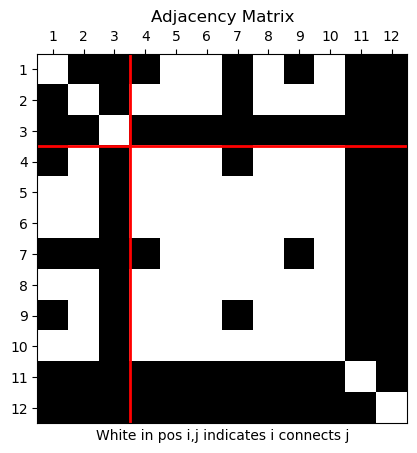

In [288]:
bandLength = 20

adjacencyMatrix = band(signatureMatrix, numHashes, n, bandLength)
plotAdjacencyMatrix(adjacencyMatrix, firstOcc, n)

In [287]:
char_vector_length = 750 #len(characteristicVector)
characteristic_matrix = np.zeros((750,n))
kmer_dict = dict()
for i in range(n):
    characteristic_matrix[:, i], kmer_dict = getCharacteristicVector(i, kmer_dict)

# This step is not performed in prediction. Shouldn't matter but noted!!
trimmed_characteristic_matrix = characteristic_matrix[0:max(np.where(characteristic_matrix > 0)[0])+1, :]

In [290]:
trimmed_characteristic_matrix.shape, signatureMatrix.shape
approx_distances = []
exact_distances = []
for i in range(12 - 1):
    for j in range(i + 1, 12):
        approx_distances.append( approx_jaccard_distance(signatureMatrix[:,i], signatureMatrix[:,j]) )
        exact_distances.append( jaccard_distance(trimmed_characteristic_matrix[:,i], trimmed_characteristic_matrix[:,j]) )

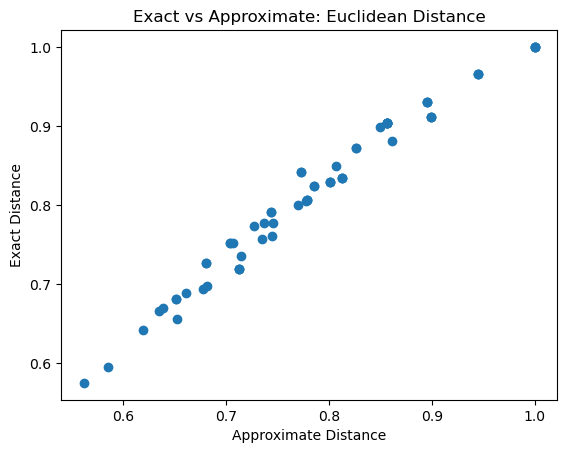

Real:
min	: 0.5747863247863247
mean	: 0.8157227663953364
max	: 1.0
var	: 0.010621749429749907

Approx:
min	: 0.562
mean	: 0.7862121212121213
max	: 1.0
var	: 0.010800773186409549


In [291]:
plot_distances(exact_distances, approx_distances, "euclidean")